In [1]:
from scipy.stats import norm
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
import arrow

## Download the data and save it as a pandas DataFrame.

In [2]:
downloadedData = yf.download("BCS ^VIX", start="2021-11-30", end="2023-11-30")
stock_data = downloadedData['Adj Close'].round(4)
ticker_symbol= "BCS"

[*********************100%%**********************]  2 of 2 completed


In [3]:
stock_data.tail()

,BCS,^VIX
Date,,
2023-11-22,7.07,12.85
2023-11-24,7.22,12.46
2023-11-27,7.14,12.69
2023-11-28,7.16,12.69
2023-11-29,7.22,12.98


(array([<Axes: xlabel='Date'>], dtype=object),
 <matplotlib.legend.Legend at 0x28479a110>)

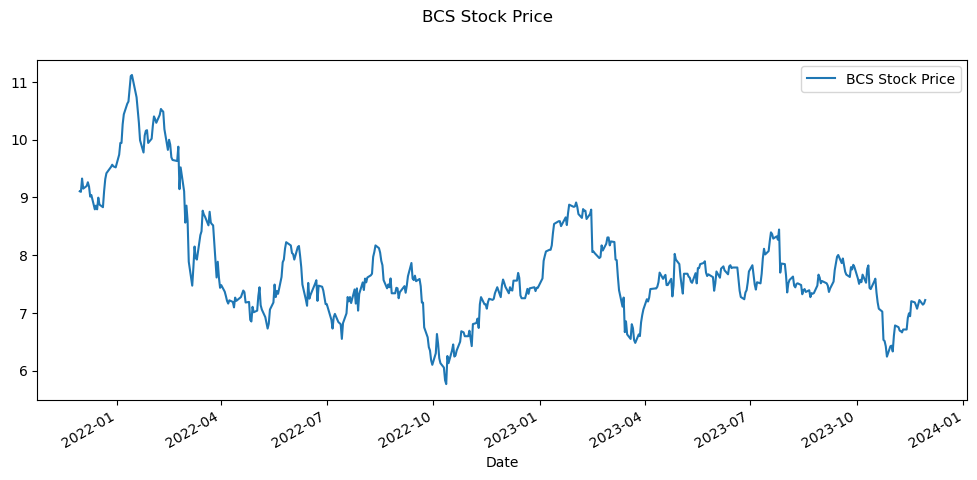

In [4]:
stock_data[ticker_symbol].plot(figsize=(12, 5), subplots=True, title="BCS Stock Price", label='BCS Stock Price' ), plt.legend(loc='best')

In [5]:
stock_data[ticker_symbol].describe().round(2)

count    503.00
mean       7.76
std        0.97
min        5.76
25%        7.23
50%        7.53
75%        8.06
max       11.12
Name: BCS, dtype: float64

<Axes: title={'center': 'Mean Daily Return'}>

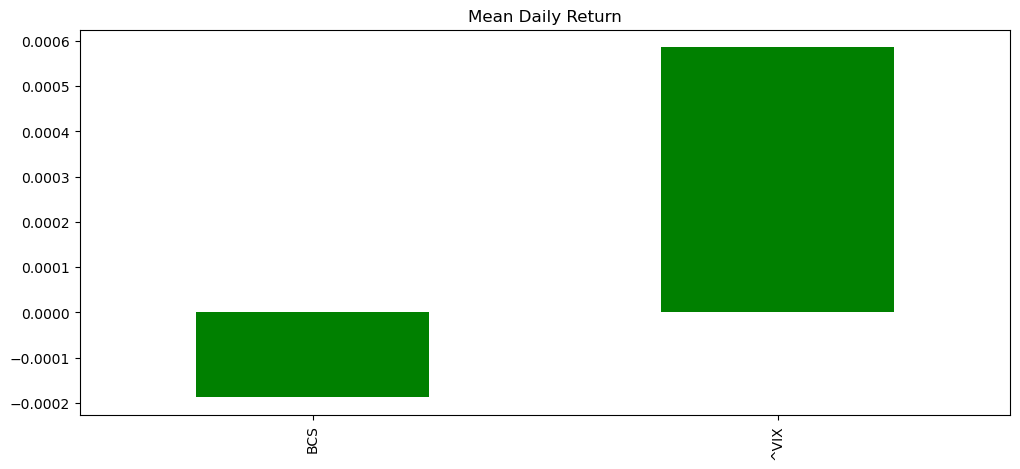

In [6]:
stock_data.pct_change().mean().plot(kind='bar', figsize=(12, 5), title="Mean Daily Return" , color='green')

In [7]:
logRets = np.log(stock_data / stock_data.shift(1))
logRets.head().round(4)

,BCS,^VIX
Date,,
2021-11-30,NaN,NaN
2021-12-01,-0.0010,0.1350
2021-12-02,0.0250,-0.1074
2021-12-03,-0.0189,0.0929
2021-12-06,0.0050,-0.1208


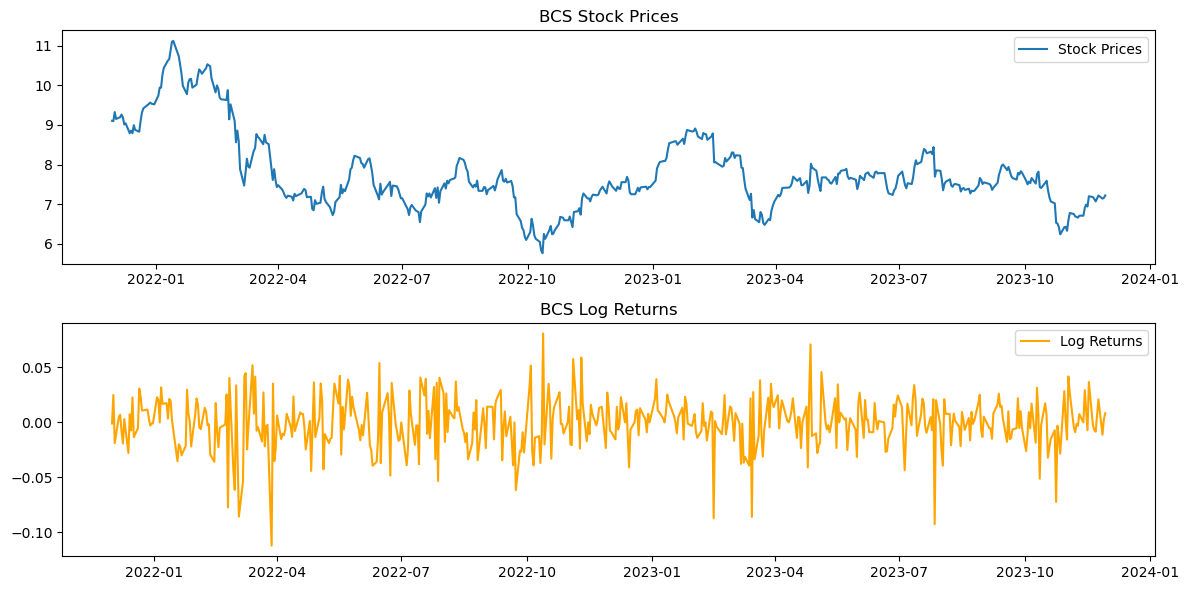

In [8]:
# Plot stock prices
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(stock_data[ticker_symbol], label='Stock Prices')
plt.title(f'{ticker_symbol} Stock Prices')
plt.legend()

# Plot log returns
plt.subplot(2, 1, 2)
plt.plot(logRets[ticker_symbol], label='Log Returns', color='orange')
plt.title(f'{ticker_symbol} Log Returns')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [9]:
logRets.describe()

,BCS,^VIX
count,502.000000,502.000000
mean,-0.000462,-0.001473
std,0.023496,0.063846
min,-0.112136,-0.216451
25%,-0.013022,-0.042694
50%,0.000000,-0.008117
75%,0.014139,0.033892
max,0.080938,0.218193


In [10]:
# Calculate annualized volatility
num_years=2
num_days=504
annualised_log_return=(1+logRets.mean())**(1/num_years)-1
annualised_log_return

BCS    -0.000231
^VIX   -0.000737
dtype: float64

In [11]:
daily_volatility=logRets.std()
annualised_volatility=daily_volatility*np.sqrt(num_days/num_years)
print(daily_volatility)
print(annualised_volatility)

BCS     0.023496
^VIX    0.063846
dtype: float64
BCS     0.372980
^VIX    1.013526
dtype: float64


In [12]:
rolling_data = pd.DataFrame(stock_data[ticker_symbol]).dropna()
rolling_data.tail()

,BCS
Date,
2023-11-22,7.07
2023-11-24,7.22
2023-11-27,7.14
2023-11-28,7.16
2023-11-29,7.22


In [13]:
window = 7
rolling_data['min'] = stock_data[ticker_symbol].rolling(window=window).min()   #the rolling minimum.
rolling_data['mean'] = stock_data[ticker_symbol].rolling(window=window).mean()
rolling_data['std'] = stock_data[ticker_symbol].rolling(window=window).std()
rolling_data['median'] = stock_data[ticker_symbol].rolling(window=window).median()
rolling_data['max'] = stock_data[ticker_symbol].rolling(window=window).max()
rolling_data['ewma'] = stock_data[ticker_symbol].ewm(halflife=0.5, min_periods=window).mean()
rolling_data.dropna().head()

,BCS,min,mean,std,median,max,ewma
Date,,,,,,,
2021-12-08,9.1861,9.0942,9.187457,0.082830,9.1861,9.3241,9.200224
2021-12-09,9.0114,9.0114,9.174314,0.103187,9.1861,9.3241,9.058604
2021-12-10,9.0390,9.0114,9.166429,0.112058,9.1861,9.3241,9.043901
2021-12-13,8.7907,8.7907,9.090229,0.158645,9.1494,9.2597,8.854000
2021-12-14,8.8551,8.7907,9.048186,0.178148,9.0390,9.2597,8.854825


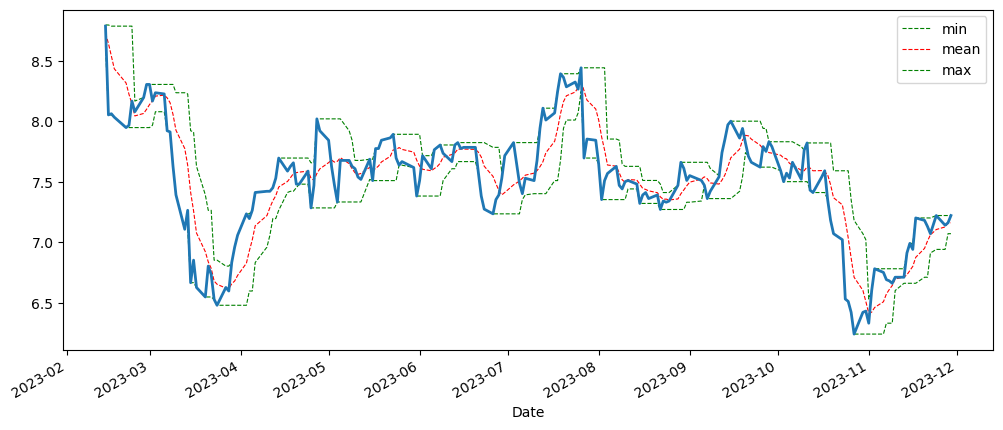

In [14]:
ax = rolling_data[['min', 'mean', 'max']].iloc[-200:].plot(figsize=(12, 5), style=['g--', 'r--', 'g--'], lw=0.8)
stock_data[ticker_symbol].iloc[-200:].plot(ax=ax, lw=2.0);

In [15]:
rolling_data['SMA1'] = stock_data[ticker_symbol].rolling(window=20).mean()
rolling_data['SMA2'] = stock_data[ticker_symbol].rolling(window=60).mean()
rolling_data[[ticker_symbol, 'SMA1', 'SMA2']].tail()

,BCS,SMA1,SMA2
Date,,,
2023-11-22,7.07,6.7420,7.278667
2023-11-24,7.22,6.7820,7.272167
2023-11-27,7.14,6.8270,7.266000
2023-11-28,7.16,6.8640,7.259500
2023-11-29,7.22,6.9035,7.254667


<Axes: xlabel='Date'>

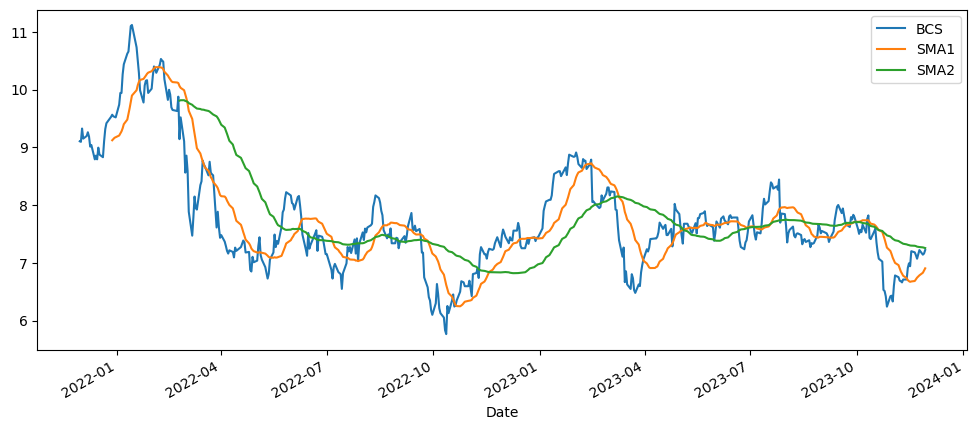

In [16]:
rolling_data[[ticker_symbol, 'SMA1', 'SMA2']].plot(figsize=(12, 5))

In [17]:
def euro_option_bsm(S, K, T, r, q, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [18]:
BCS = yf.Ticker(ticker_symbol)
opt = BCS.option_chain('2023-12-15')
opt.puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,BCS231215P00002000,2023-06-12 18:03:24+00:00,2.0,0.02,0.00,0.00,0.00,0.000000,NaN,1,0.500005,False,REGULAR,USD
1,BCS231215P00004000,2023-05-19 18:08:43+00:00,4.0,0.10,0.00,0.00,0.00,0.000000,1.0,0,0.500005,False,REGULAR,USD
2,BCS231215P00005000,2023-06-22 15:59:53+00:00,5.0,0.09,0.00,0.75,0.00,0.000000,NaN,10,2.742191,False,REGULAR,USD
3,BCS231215P00006000,2023-11-24 17:41:56+00:00,6.0,0.05,0.00,0.10,0.00,0.000000,1.0,2059,0.867189,False,REGULAR,USD
4,BCS231215P00007000,2023-12-04 14:33:58+00:00,7.0,0.04,0.00,0.05,-0.01,-20.000004,1.0,7668,0.316413,False,REGULAR,USD
5,BCS231215P00008000,2023-10-27 17:30:37+00:00,8.0,1.71,0.60,0.80,0.00,0.000000,17.0,0,0.664066,True,REGULAR,USD
6,BCS231215P00009000,2023-09-13 13:36:01+00:00,9.0,1.15,1.50,1.60,0.00,0.000000,621.0,650,0.000010,True,REGULAR,USD
7,BCS231215P00010000,2023-09-14 17:14:06+00:00,10.0,1.99,2.35,2.65,0.00,0.000000,1.0,0,0.000010,True,REGULAR,USD
8,BCS231215P00011000,2023-07-20 18:52:13+00:00,11.0,2.50,3.60,4.20,0.00,0.000000,3.0,0,2.039067,True,REGULAR,USD
9,BCS231215P00013000,2023-08-17 18:00:38+00:00,13.0,5.60,4.90,5.10,0.00,0.000000,NaN,1,0.000010,True,REGULAR,USD


In [19]:
BCS_data= yf.download("BCS", start="2021-11-30", end="2023-12-30")

[*********************100%%**********************]  1 of 1 completed


In [20]:
S = BCS_data['Adj Close'][-1]
K = opt.calls['strike']
T = 1/4
r = 0.0382
q = 0.0
log_return = np.log(BCS_data['Adj Close'] / BCS_data['Adj Close'].shift(1))
vol = np.sqrt(252) * log_return.std() 
vol

/var/folders/7d/rshw9ymn60nb8gzr2xqdzbsw0000gn/T/ipykernel_12294/345391463.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = BCS_data['Adj Close'][-1]


0.372354738803689

In [21]:
Stock_price = BCS_data['Adj Close'][-1]
Time = 1/4
rr = 0.0382
divident = 0.0
log_return = np.log(BCS_data['Adj Close'] / BCS_data['Adj Close'].shift(1))
vol = np.sqrt(252) * log_return.std() 

euro_option_bsm(S, 9, T, r, q, vol, 'put')

/var/folders/7d/rshw9ymn60nb8gzr2xqdzbsw0000gn/T/ipykernel_12294/187433419.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Stock_price = BCS_data['Adj Close'][-1]


1.7019427871213173

In [22]:
BCS_bsm_put = np.zeros((len(K),1))
for i in range(len(K)):
    BCS_bsm_put [i] = euro_option_bsm(S, K[i], T, r, q, vol, 'put')

In [23]:
opt.puts['BSMPrice'] = pd.DataFrame(BCS_bsm_put).round(6)
opt.puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,BSMPrice
0,BCS231215P00002000,2023-06-12 18:03:24+00:00,2.0,0.02,0.00,0.00,0.00,0.000000,NaN,1,0.500005,False,REGULAR,USD,0.000000
1,BCS231215P00004000,2023-05-19 18:08:43+00:00,4.0,0.10,0.00,0.00,0.00,0.000000,1.0,0,0.500005,False,REGULAR,USD,0.007182
2,BCS231215P00005000,2023-06-22 15:59:53+00:00,5.0,0.09,0.00,0.75,0.00,0.000000,NaN,10,2.742191,False,REGULAR,USD,0.080293
3,BCS231215P00006000,2023-11-24 17:41:56+00:00,6.0,0.05,0.00,0.10,0.00,0.000000,1.0,2059,0.867189,False,REGULAR,USD,0.355765
4,BCS231215P00007000,2023-12-04 14:33:58+00:00,7.0,0.04,0.00,0.05,-0.01,-20.000004,1.0,7668,0.316413,False,REGULAR,USD,0.914448
5,BCS231215P00008000,2023-10-27 17:30:37+00:00,8.0,1.71,0.60,0.80,0.00,0.000000,17.0,0,0.664066,True,REGULAR,USD,1.701943
6,BCS231215P00009000,2023-09-13 13:36:01+00:00,9.0,1.15,1.50,1.60,0.00,0.000000,621.0,650,0.000010,True,REGULAR,USD,2.614937
7,BCS231215P00010000,2023-09-14 17:14:06+00:00,10.0,1.99,2.35,2.65,0.00,0.000000,1.0,0,0.000010,True,REGULAR,USD,NaN
8,BCS231215P00011000,2023-07-20 18:52:13+00:00,11.0,2.50,3.60,4.20,0.00,0.000000,3.0,0,2.039067,True,REGULAR,USD,NaN
9,BCS231215P00013000,2023-08-17 18:00:38+00:00,13.0,5.60,4.90,5.10,0.00,0.000000,NaN,1,0.000010,True,REGULAR,USD,NaN


In [24]:
opt.puts['estimate_error'] = ((opt.puts['BSMPrice'] - opt.puts['lastPrice'])/opt.puts['lastPrice'])*100
opt.puts['estimate_error']

0    -100.000000
1     -92.818000
2     -10.785556
3     611.530000
4    2186.120000
5      -0.471170
6     127.385826
7            NaN
8            NaN
9            NaN
Name: estimate_error, dtype: float64

In [25]:
opt.puts['estimate_error'].replace([np.inf, -np.inf], np.nan).dropna(axis=0).describe()

count       7.000000
mean      388.708729
std       829.697449
min      -100.000000
25%       -51.801778
50%        -0.471170
75%       369.457913
max      2186.120000
Name: estimate_error, dtype: float64

Text(0.5, 1.0, 'Histogram of Estimate Error')

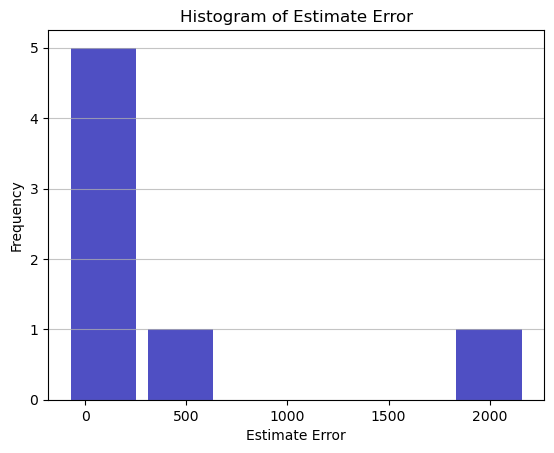

In [26]:
n, bins, patches = plt.hist(x=opt.puts['estimate_error'].replace([np.inf, -np.inf], np.nan).dropna(axis=0), bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Estimate Error')
plt.ylabel('Frequency')
plt.title('Histogram of Estimate Error')

In [27]:
S = BCS_data['Adj Close'][-1]
K= 9
T = 1/4
r = 0.0382
q = 0.0
log_return = np.log(BCS_data['Adj Close'] / BCS_data['Adj Close'].shift(1))
vol = np.sqrt(252) * log_return.std() 

def monte_carlo(number):
    
    time_frame=12*T
    dt= T/time_frame

    st_stock=np.zeros((int(time_frame)+1,number))
    st_stock[0]=S
    rn=np.random.standard_normal(st_stock.shape)

    for t in range(1,int(time_frame)+1):
        st_stock[t]=st_stock[t-1]*np.exp((r-vol**2/2)*dt+vol*np.sqrt(dt) *rn[t])
        
    return st_stock

simulated_stocks=monte_carlo(1000)
simulated_stocks


/var/folders/7d/rshw9ymn60nb8gzr2xqdzbsw0000gn/T/ipykernel_12294/2735083147.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = BCS_data['Adj Close'][-1]


array([[7.32499981, 7.32499981, 7.32499981, ..., 7.32499981, 7.32499981,
        7.32499981],
       [7.1371971 , 7.31272201, 5.85817376, ..., 8.36852852, 7.31502543,
        7.40055441],
       [5.99122245, 7.38964492, 5.76235286, ..., 9.46078056, 6.79390067,
        7.39075239],
       [5.06791241, 7.57587457, 6.75606061, ..., 9.11687384, 6.8189885 ,
        8.33314525]])

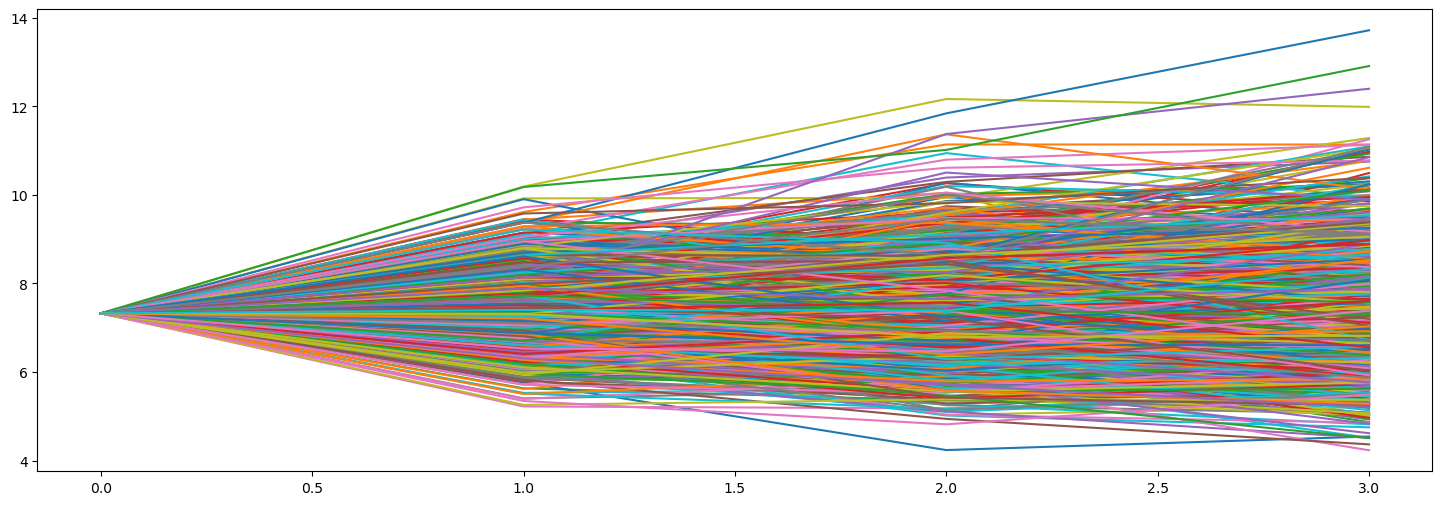

In [28]:
fig = plt.figure(figsize=(18,6))
plt.plot(simulated_stocks)
plt.show()

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

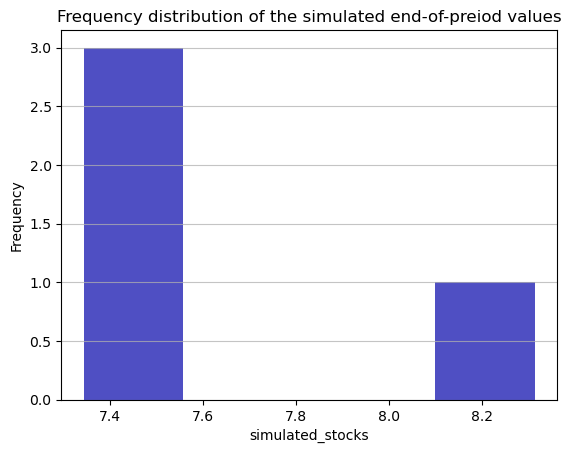

In [29]:
n, bins, patches = plt.hist(x=simulated_stocks[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('simulated_stocks')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [30]:
def monte_carlo(number):
   time_frame=int(12*T)
   dt= T/time_frame

   st_stock=np.zeros((time_frame+1,number)) 
   st_stock[0]=S
   
   for t in range(1,time_frame+1):
       st_stock[t]=st_stock[t-1]*np.exp((r-vol**2/2)*dt+vol*np.sqrt(dt) * np.random.standard_normal(size=number)) 
       
   return st_stock
   
# Call monte carlo simulation   
simulated_stocks = monte_carlo(1000) 

payoffs = np.maximum(K - simulated_stocks[-1,:], 0)   

df = np.exp(-r * T)   

price = df * payoffs.mean() 

print("European Put Option Price: ", round(price, 3))

European Put Option Price:  1.663


In [31]:
def delta(stock_price, strike_price, time_to_expiration, risk_free_rate, annualised_volatility, payoff):
    
    d1 = (np.log(stock_price / strike_price) + (risk_free_rate + 0.5 * annualised_volatility ** 2) * time_to_expiration) / (annualised_volatility * np.sqrt(time_to_expiration))
    delta = norm.cdf(d1, 0.0, 1.0) - 1
    
    return delta


put_delta = delta(S, 9, T, r, vol, payoff="put")
print("Put Delta:", put_delta)

Put Delta: -0.8319047856229376


In [32]:
St = np.linspace(50,150,11)
Delta_Put = np.zeros((len(St),1))
for i in range(len(St)):
    Delta_Put [i] = delta(St[i], 9, T, r, vol, 'put')

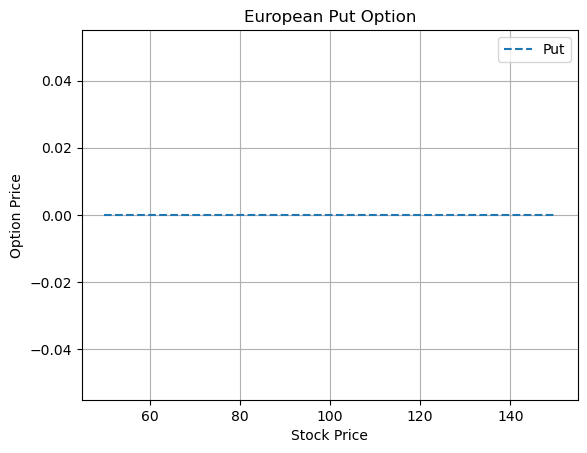

In [33]:
fig = plt.figure()
plt.plot(St, Delta_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Put Option')
plt.legend(['Put'])

In [34]:
def gamma(Stock_price, strike_price, time_to_expiration, risk_free_rate,  annualised_volatility, payoff):
    
    d1 = (np.log(Stock_price / strike_price) + (risk_free_rate  + 0.5 * annualised_volatility ** 2) * time_to_expiration) / (annualised_volatility * np.sqrt(time_to_expiration))

    gamma = si.norm.pdf(d1, 0.0, 1.0) / (annualised_volatility *  np.sqrt(time_to_expiration) * Stock_price)
    return gamma

In [35]:
gamma(S, 9, T, r, vol, 'put')

0.1842192632621735

In [36]:
St = np.linspace(50,150,11)
gamma_Put = np.zeros((len(St),1))
for i in range(len(St)):
    gamma_Put [i] = gamma(St[i], K, T, r, vol, 'put')

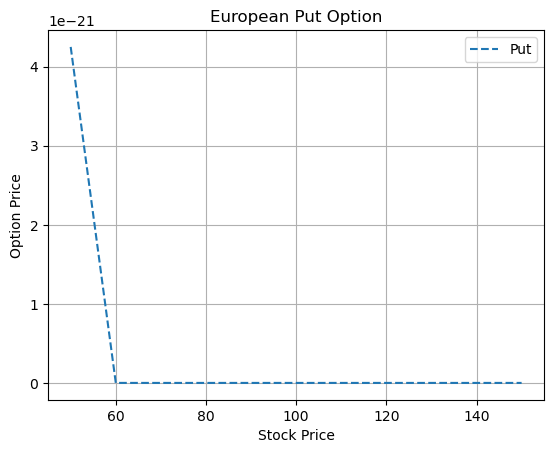

In [37]:
fig = plt.figure()
plt.plot(St, gamma_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Put Option')
plt.legend(['Put'])

In [38]:
def theta(Stock_price, strike_price, time_to_expiration, risk_free_rate, annualised_volatility, payoff):
    d1 = (np.log(Stock_price / strike_price) + (risk_free_rate + 0.5 * annualised_volatility ** 2) * time_to_expiration) / (annualised_volatility * np.sqrt(time_to_expiration))
    d2 = (np.log(Stock_price / strike_price) + (risk_free_rate - 0.5 * annualised_volatility ** 2) * time_to_expiration) / (annualised_volatility * np.sqrt(time_to_expiration))
    N_d1_prime=1/np.sqrt(2 * np.pi) * np.exp(-d1**2/2)
    theta = - Stock_price * N_d1_prime * annualised_volatility / (2 * np.sqrt(time_to_expiration)) + risk_free_rate * strike_price * np.exp(-risk_free_rate * time_to_expiration) * si.norm.cdf(-d2, 0.0, 1.0)
    return theta

In [39]:
theta(S, K, T, r, vol, 'put')

-0.38743269820351023

In [40]:
St = np.linspace(50,150,11)
theta_Put = np.zeros((len(St),1))
for i in range(len(St)):
    theta_Put[i] = theta(St[i], K, T, r, vol, 'put')

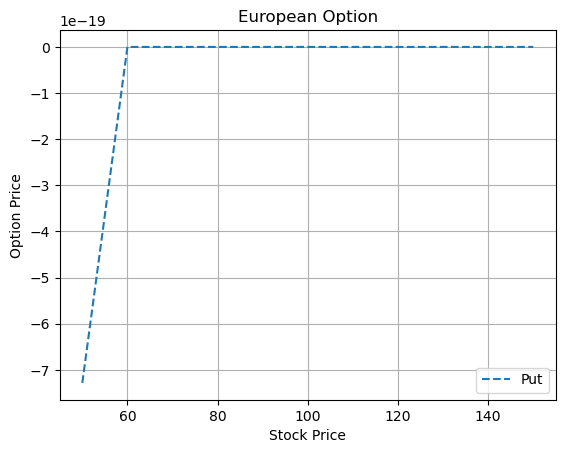

In [41]:
fig = plt.figure()
plt.plot(St, theta_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option')
plt.legend(['Put'])

In [42]:
def rho(S, K, T, r, vol, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [43]:
rho(S, K, T, r, vol, 'put')

-1.9489112957840224

In [44]:
St = np.linspace(50,150,11)
rho_Put = np.zeros((len(St),1))
for i in range(len(St)):
    rho_Put[i] = rho(St[i], K, T, r, vol, 'put')

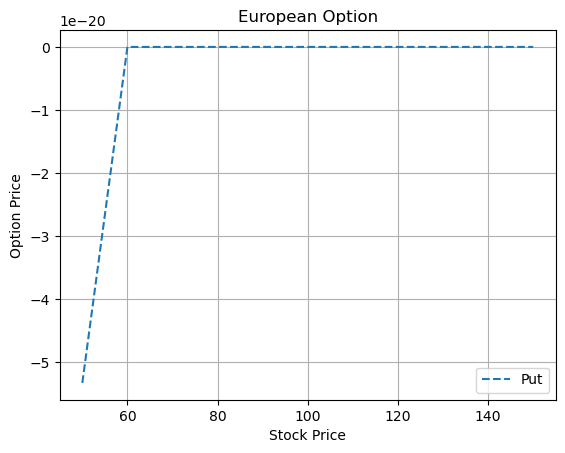

In [45]:
fig = plt.figure()
plt.plot(St, rho_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option')
plt.legend(['Put'])